# Centralized learning for ECG Arrhythmia detection


In [1]:
import configparser
import os
from pathlib import Path

import lightning as L
import matplotlib.pyplot as plt
import wandb
from dotenv import load_dotenv
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
from lightning.pytorch.loggers import TensorBoardLogger, WandbLogger

from dataset_utils import Cinc2017DataModule
from model import DenseNetGruEcgModule

/home/g113056077/.pyenv/versions/awin-ecg/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Config


In [2]:
load_dotenv()
wandb_mode = os.getenv("WANDB_MODE")

config = configparser.ConfigParser()
config.read("config.ini")
dst_freq = config.getint("data_preprocessing", "dst_freq")
seg_time = config.getint("data_preprocessing", "seg_time")
dst_length = dst_freq * seg_time

MAX_EPOCHS = 50

## Prepare the Dataset


In [3]:
dm = Cinc2017DataModule(batch_size=512)

## Create the Model


In [4]:
model = DenseNetGruEcgModule(
    max_epochs=MAX_EPOCHS,
    num_classes=dm.num_classes,
    input_length=dst_length,
    lr_scheduler_mode="multi_step",
    lr=1e-3,
    # min_lr = 1e-4,
    show_valid_cm=True,
    growth_rate=16,
    block_config=(12, 12, 24, 16, 16),
    num_init_features=64,
    bn_size=4,
    db_drop_rate=0.2,
    gru_drop_rate=0.2,
    fc_drop_rate=0.2,
    memory_efficient=False,
    compression_factor=0.5,
)

# the number of features per denseblock:
# (64 + 4 * 16) // 2 = 64
# (64 + 4 * 16) // 2 = 64
# (64 + 12 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (128 + 8 * 16) // 2 = 128
# (256 + 8 * 16) // 2 = 128

# the number of features per denseblock:
# (64 + 12 * 16) // 2 = 128
# (64 + 12 * 16) // 2 = 128
# (128 + 24 * 16) // 2 = 256
# (256 + 16 * 16) // 2 = 256
# (256 + 16 * 16) = 512


## Create the Trainer


In [5]:
checkpoint_callback = ModelCheckpoint(
    monitor="valid_auprc",
    verbose=True,
    mode="max",
    save_top_k=1,
    save_last=True,
)

# early_stopping_callback = EarlyStopping(
#     monitor="valid_loss", patience=8, verbose=True, mode="min"
# )

progress_bar_callback = TQDMProgressBar(leave=True)

project_name = "awin-ecg-centralized"
if wandb_mode == "disabled":
    logger = TensorBoardLogger(save_dir=Path("tb_logs"), name=project_name)
else:
    logger = WandbLogger(
        project=project_name, save_dir=Path("wandb_logs"), log_model=True, name=project_name
    )

trainer = L.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[checkpoint_callback, progress_bar_callback],
    logger=logger,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## Train the Model


In [6]:
trainer.fit(model, datamodule=dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type                      | Params | Mode  | In sizes    | Out sizes
----------------------------------------------------------------------------------------------
0 | model         | DenseNetGruEcg            | 2.3 M  | train | [1, 1, 300] | [1, 3]   
1 | loss_fn       | CrossEntropyLoss          | 0      | train | ?           | ?        
2 | train_metrics | MetricCollection          | 0      | train | ?           | ?        
3 | valid_metrics | MetricCollection          | 0      | train | ?           | ?        
4 | test_metrics  | MetricCollection          | 0      | train | ?           | ?        
5 | valid_cm      | MulticlassConfusionMatrix | 0      | train | ?           | ?        
6 | test_cm       | MulticlassConfusionMatrix | 0      | train | ?           | ?        
----------------------------------------------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable para

Training: |          | 0/? [00:00<?, ?it/s]                                
Epoch 0: 100%|██████████| 112/112 [00:34<00:00,  3.27it/s, v_num=0, lr=0.001, valid_loss=0.720, valid_acc=0.704, valid_auprc=0.646, valid_auroc=0.819, valid_f1=0.628, train_loss=0.888, train_acc=0.568, train_auprc=0.613, train_auroc=0.757, train_f1=0.563]

Epoch 0, global step 112: 'valid_auprc' reached 0.64622 (best 0.64622), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=0-step=112.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6049,  372,  893],
        [  79,  859,  110],
        [1352,  777, 1599]], device='cuda:0')
Epoch 1: 100%|██████████| 112/112 [00:34<00:00,  3.24it/s, v_num=0, lr=0.001, valid_loss=0.668, valid_acc=0.721, valid_auprc=0.675, valid_auroc=0.832, valid_f1=0.624, train_loss=0.711, train_acc=0.683, train_auprc=0.727, train_auroc=0.845, train_f1=0.675]

Epoch 1, global step 224: 'valid_auprc' reached 0.67491 (best 0.67491), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=1-step=224.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6631,  280,  403],
        [ 106,  841,  101],
        [1727,  753, 1248]], device='cuda:0')
Epoch 2: 100%|██████████| 112/112 [00:34<00:00,  3.23it/s, v_num=0, lr=0.001, valid_loss=0.685, valid_acc=0.724, valid_auprc=0.694, valid_auroc=0.835, valid_f1=0.661, train_loss=0.656, train_acc=0.711, train_auprc=0.765, train_auroc=0.867, train_f1=0.705]

Epoch 2, global step 336: 'valid_auprc' reached 0.69416 (best 0.69416), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=2-step=336.ckpt' as top 1



Valid Confusion Matrix:
tensor([[5995,  306, 1013],
        [  56,  824,  168],
        [1214,  582, 1932]], device='cuda:0')
Epoch 3: 100%|██████████| 112/112 [00:34<00:00,  3.21it/s, v_num=0, lr=0.001, valid_loss=0.672, valid_acc=0.728, valid_auprc=0.711, valid_auroc=0.841, valid_f1=0.670, train_loss=0.628, train_acc=0.724, train_auprc=0.779, train_auroc=0.876, train_f1=0.718]

Epoch 3, global step 448: 'valid_auprc' reached 0.71128 (best 0.71128), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=3-step=448.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6042,  327,  945],
        [  45,  846,  157],
        [1292,  517, 1919]], device='cuda:0')
Epoch 4: 100%|██████████| 112/112 [00:34<00:00,  3.20it/s, v_num=0, lr=0.001, valid_loss=0.645, valid_acc=0.738, valid_auprc=0.723, valid_auroc=0.847, valid_f1=0.682, train_loss=0.607, train_acc=0.731, train_auprc=0.792, train_auroc=0.883, train_f1=0.726]

Epoch 4, global step 560: 'valid_auprc' reached 0.72342 (best 0.72342), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=4-step=560.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6121,  256,  937],
        [  63,  830,  155],
        [1290,  469, 1969]], device='cuda:0')
Epoch 5: 100%|██████████| 112/112 [00:35<00:00,  3.20it/s, v_num=0, lr=0.001, valid_loss=0.622, valid_acc=0.751, valid_auprc=0.733, valid_auroc=0.852, valid_f1=0.692, train_loss=0.582, train_acc=0.746, train_auprc=0.806, train_auroc=0.892, train_f1=0.740]

Epoch 5, global step 672: 'valid_auprc' reached 0.73302 (best 0.73302), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=5-step=672.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6282,  180,  852],
        [  78,  769,  201],
        [1308,  394, 2026]], device='cuda:0')
Epoch 6: 100%|██████████| 112/112 [00:35<00:00,  3.18it/s, v_num=0, lr=0.001, valid_loss=0.758, valid_acc=0.679, valid_auprc=0.710, valid_auroc=0.834, valid_f1=0.632, train_loss=0.562, train_acc=0.752, train_auprc=0.816, train_auroc=0.898, train_f1=0.747]

Epoch 6, global step 784: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5166,  558, 1590],
        [  30,  860,  158],
        [ 913,  630, 2185]], device='cuda:0')
Epoch 7: 100%|██████████| 112/112 [00:35<00:00,  3.18it/s, v_num=0, lr=0.001, valid_loss=0.638, valid_acc=0.749, valid_auprc=0.733, valid_auroc=0.852, valid_f1=0.685, train_loss=0.553, train_acc=0.758, train_auprc=0.822, train_auroc=0.901, train_f1=0.755]

Epoch 7, global step 896: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6315,  286,  713],
        [  75,  818,  155],
        [1345,  460, 1923]], device='cuda:0')
Epoch 8: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.001, valid_loss=0.651, valid_acc=0.742, valid_auprc=0.724, valid_auroc=0.842, valid_f1=0.678, train_loss=0.528, train_acc=0.768, train_auprc=0.834, train_auroc=0.909, train_f1=0.764]

Epoch 8, global step 1008: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6332,  257,  725],
        [  77,  827,  144],
        [1435,  478, 1815]], device='cuda:0')
Epoch 9: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.001, valid_loss=0.752, valid_acc=0.735, valid_auprc=0.724, valid_auroc=0.844, valid_f1=0.648, train_loss=0.520, train_acc=0.771, train_auprc=0.837, train_auroc=0.910, train_f1=0.766]

Epoch 9, global step 1120: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6468,  483,  363],
        [  50,  909,   89],
        [1473,  751, 1504]], device='cuda:0')
Epoch 10: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.001, valid_loss=0.681, valid_acc=0.734, valid_auprc=0.734, valid_auroc=0.845, valid_f1=0.665, train_loss=0.498, train_acc=0.782, train_auprc=0.847, train_auroc=0.917, train_f1=0.778]

Epoch 10, global step 1232: 'valid_auprc' reached 0.73385 (best 0.73385), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=10-step=1232.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6226,  380,  708],
        [  71,  848,  129],
        [1362,  565, 1801]], device='cuda:0')
Epoch 11: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.001, valid_loss=0.641, valid_acc=0.756, valid_auprc=0.743, valid_auroc=0.853, valid_f1=0.691, train_loss=0.476, train_acc=0.791, train_auprc=0.857, train_auroc=0.923, train_f1=0.787]

Epoch 11, global step 1344: 'valid_auprc' reached 0.74271 (best 0.74271), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=11-step=1344.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6557,  232,  525],
        [  81,  799,  168],
        [1578,  366, 1784]], device='cuda:0')
Epoch 12: 100%|██████████| 112/112 [00:35<00:00,  3.14it/s, v_num=0, lr=0.001, valid_loss=0.626, valid_acc=0.758, valid_auprc=0.743, valid_auroc=0.852, valid_f1=0.698, train_loss=0.468, train_acc=0.794, train_auprc=0.861, train_auroc=0.925, train_f1=0.791]

Epoch 12, global step 1456: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6501,  190,  623],
        [  98,  756,  194],
        [1509,  306, 1913]], device='cuda:0')
Epoch 13: 100%|██████████| 112/112 [00:35<00:00,  3.14it/s, v_num=0, lr=0.001, valid_loss=0.695, valid_acc=0.736, valid_auprc=0.741, valid_auroc=0.849, valid_f1=0.670, train_loss=0.457, train_acc=0.799, train_auprc=0.867, train_auroc=0.928, train_f1=0.797]

Epoch 13, global step 1568: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6186,  384,  744],
        [  44,  892,  112],
        [1303,  608, 1817]], device='cuda:0')
Epoch 14: 100%|██████████| 112/112 [00:35<00:00,  3.14it/s, v_num=0, lr=0.001, valid_loss=0.684, valid_acc=0.747, valid_auprc=0.741, valid_auroc=0.849, valid_f1=0.689, train_loss=0.445, train_acc=0.805, train_auprc=0.873, train_auroc=0.932, train_f1=0.803]

Epoch 14, global step 1680: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6292,  230,  792],
        [  74,  827,  147],
        [1374,  439, 1915]], device='cuda:0')
Epoch 15: 100%|██████████| 112/112 [00:35<00:00,  3.14it/s, v_num=0, lr=0.001, valid_loss=0.711, valid_acc=0.742, valid_auprc=0.734, valid_auroc=0.845, valid_f1=0.679, train_loss=0.430, train_acc=0.811, train_auprc=0.878, train_auroc=0.935, train_f1=0.809]

Epoch 15, global step 1792: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6285,  255,  774],
        [  83,  845,  120],
        [1372,  518, 1838]], device='cuda:0')
Epoch 16: 100%|██████████| 112/112 [00:35<00:00,  3.14it/s, v_num=0, lr=0.001, valid_loss=0.719, valid_acc=0.734, valid_auprc=0.738, valid_auroc=0.845, valid_f1=0.669, train_loss=0.417, train_acc=0.818, train_auprc=0.886, train_auroc=0.939, train_f1=0.816]

Epoch 16, global step 1904: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6134,  409,  771],
        [  48,  882,  118],
        [1291,  580, 1857]], device='cuda:0')
Epoch 17: 100%|██████████| 112/112 [00:35<00:00,  3.14it/s, v_num=0, lr=0.001, valid_loss=0.696, valid_acc=0.742, valid_auprc=0.740, valid_auroc=0.849, valid_f1=0.700, train_loss=0.413, train_acc=0.819, train_auprc=0.887, train_auroc=0.940, train_f1=0.817]

Epoch 17, global step 2016: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5967,  194, 1153],
        [  48,  807,  193],
        [1187,  344, 2197]], device='cuda:0')
Epoch 18: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.001, valid_loss=0.680, valid_acc=0.751, valid_auprc=0.741, valid_auroc=0.851, valid_f1=0.697, train_loss=0.398, train_acc=0.827, train_auprc=0.892, train_auroc=0.943, train_f1=0.826]

Epoch 18, global step 2128: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6265,  238,  811],
        [  71,  810,  167],
        [1373,  356, 1999]], device='cuda:0')
Epoch 19: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.001, valid_loss=0.716, valid_acc=0.725, valid_auprc=0.736, valid_auroc=0.845, valid_f1=0.685, train_loss=0.390, train_acc=0.830, train_auprc=0.897, train_auroc=0.945, train_f1=0.829]

Epoch 19, global step 2240: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5764,  217, 1333],
        [  62,  786,  200],
        [1177,  341, 2210]], device='cuda:0')
Epoch 20: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.001, valid_loss=0.836, valid_acc=0.658, valid_auprc=0.728, valid_auroc=0.842, valid_f1=0.653, train_loss=0.381, train_acc=0.833, train_auprc=0.901, train_auroc=0.947, train_f1=0.832]

Epoch 20, global step 2352: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[4547,  146, 2621],
        [  40,  748,  260],
        [ 774,  295, 2659]], device='cuda:0')
Epoch 21: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.001, valid_loss=0.707, valid_acc=0.757, valid_auprc=0.741, valid_auroc=0.851, valid_f1=0.699, train_loss=0.372, train_acc=0.837, train_auprc=0.905, train_auroc=0.950, train_f1=0.836]

Epoch 21, global step 2464: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6438,  171,  705],
        [  84,  803,  161],
        [1423,  393, 1912]], device='cuda:0')
Epoch 22: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.001, valid_loss=0.748, valid_acc=0.736, valid_auprc=0.736, valid_auroc=0.846, valid_f1=0.679, train_loss=0.361, train_acc=0.844, train_auprc=0.910, train_auroc=0.952, train_f1=0.842]

Epoch 22, global step 2576: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6061,  319,  934],
        [  42,  819,  187],
        [1256,  449, 2023]], device='cuda:0')
Epoch 23: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.001, valid_loss=0.760, valid_acc=0.716, valid_auprc=0.734, valid_auroc=0.843, valid_f1=0.678, train_loss=0.354, train_acc=0.847, train_auprc=0.914, train_auroc=0.954, train_f1=0.846]

Epoch 23, global step 2688: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5624,  231, 1459],
        [  45,  810,  193],
        [1099,  405, 2224]], device='cuda:0')
Epoch 24: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.001, valid_loss=0.706, valid_acc=0.762, valid_auprc=0.750, valid_auroc=0.852, valid_f1=0.707, train_loss=0.346, train_acc=0.852, train_auprc=0.916, train_auroc=0.956, train_f1=0.851]

Epoch 24, global step 2800: 'valid_auprc' reached 0.75011 (best 0.75011), saving model to 'tb_logs/awin-ecg-centralized/version_0/checkpoints/epoch=24-step=2800.ckpt' as top 1



Valid Confusion Matrix:
tensor([[6552,  155,  607],
        [  80,  818,  150],
        [1547,  338, 1843]], device='cuda:0')
Epoch 25: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.0005, valid_loss=0.744, valid_acc=0.736, valid_auprc=0.744, valid_auroc=0.851, valid_f1=0.701, train_loss=0.316, train_acc=0.864, train_auprc=0.929, train_auroc=0.963, train_f1=0.863]

Epoch 25, global step 2912: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5841,  133, 1340],
        [  56,  752,  240],
        [1155,  264, 2309]], device='cuda:0')
Epoch 26: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.0005, valid_loss=0.782, valid_acc=0.733, valid_auprc=0.739, valid_auroc=0.844, valid_f1=0.694, train_loss=0.309, train_acc=0.868, train_auprc=0.932, train_auroc=0.964, train_f1=0.868]

Epoch 26, global step 3024: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5887,  201, 1226],
        [  66,  818,  164],
        [1216,  356, 2156]], device='cuda:0')
Epoch 27: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.769, valid_acc=0.748, valid_auprc=0.737, valid_auroc=0.846, valid_f1=0.703, train_loss=0.296, train_acc=0.874, train_auprc=0.937, train_auroc=0.967, train_f1=0.874]

Epoch 27, global step 3136: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6245,  147,  922],
        [  76,  797,  175],
        [1414,  312, 2002]], device='cuda:0')
Epoch 28: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.815, valid_acc=0.730, valid_auprc=0.730, valid_auroc=0.841, valid_f1=0.689, train_loss=0.287, train_acc=0.878, train_auprc=0.939, train_auroc=0.968, train_f1=0.878]

Epoch 28, global step 3248: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5883,  223, 1208],
        [  56,  817,  175],
        [1243,  358, 2127]], device='cuda:0')
Epoch 29: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.815, valid_acc=0.734, valid_auprc=0.727, valid_auroc=0.840, valid_f1=0.698, train_loss=0.285, train_acc=0.879, train_auprc=0.941, train_auroc=0.969, train_f1=0.878]

Epoch 29, global step 3360: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5917,  123, 1274],
        [  72,  750,  226],
        [1250,  267, 2211]], device='cuda:0')
Epoch 30: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.0005, valid_loss=0.832, valid_acc=0.735, valid_auprc=0.738, valid_auroc=0.850, valid_f1=0.701, train_loss=0.280, train_acc=0.882, train_auprc=0.943, train_auroc=0.970, train_f1=0.881]

Epoch 30, global step 3472: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5829,  123, 1362],
        [  60,  749,  239],
        [1146,  269, 2313]], device='cuda:0')
Epoch 31: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.801, valid_acc=0.726, valid_auprc=0.738, valid_auroc=0.843, valid_f1=0.692, train_loss=0.273, train_acc=0.886, train_auprc=0.947, train_auroc=0.972, train_f1=0.886]

Epoch 31, global step 3584: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5723,  139, 1452],
        [  65,  728,  255],
        [1167,  238, 2323]], device='cuda:0')
Epoch 32: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.815, valid_acc=0.743, valid_auprc=0.737, valid_auroc=0.844, valid_f1=0.700, train_loss=0.270, train_acc=0.886, train_auprc=0.948, train_auroc=0.973, train_f1=0.886]

Epoch 32, global step 3696: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6081,  158, 1075],
        [  66,  775,  207],
        [1308,  293, 2127]], device='cuda:0')
Epoch 33: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.831, valid_acc=0.745, valid_auprc=0.738, valid_auroc=0.844, valid_f1=0.698, train_loss=0.268, train_acc=0.888, train_auprc=0.949, train_auroc=0.973, train_f1=0.888]

Epoch 33, global step 3808: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6193,  146,  975],
        [  83,  767,  198],
        [1378,  302, 2048]], device='cuda:0')
Epoch 34: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.843, valid_acc=0.740, valid_auprc=0.737, valid_auroc=0.845, valid_f1=0.699, train_loss=0.256, train_acc=0.893, train_auprc=0.953, train_auroc=0.975, train_f1=0.893]

Epoch 34, global step 3920: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6055,  164, 1095],
        [  60,  790,  198],
        [1324,  303, 2101]], device='cuda:0')
Epoch 35: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.0005, valid_loss=0.917, valid_acc=0.705, valid_auprc=0.728, valid_auroc=0.838, valid_f1=0.680, train_loss=0.256, train_acc=0.893, train_auprc=0.953, train_auroc=0.975, train_f1=0.892]

Epoch 35, global step 4032: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5407,  135, 1772],
        [  61,  752,  235],
        [1065,  295, 2368]], device='cuda:0')
Epoch 36: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.0005, valid_loss=0.869, valid_acc=0.744, valid_auprc=0.736, valid_auroc=0.842, valid_f1=0.695, train_loss=0.249, train_acc=0.896, train_auprc=0.955, train_auroc=0.976, train_f1=0.896]

Epoch 36, global step 4144: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6197,  156,  961],
        [  83,  779,  186],
        [1372,  337, 2019]], device='cuda:0')
Epoch 37: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.00025, valid_loss=0.869, valid_acc=0.740, valid_auprc=0.737, valid_auroc=0.843, valid_f1=0.701, train_loss=0.235, train_acc=0.903, train_auprc=0.960, train_auroc=0.979, train_f1=0.903]

Epoch 37, global step 4256: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6016,  114, 1184],
        [  73,  760,  215],
        [1279,  280, 2169]], device='cuda:0')
Epoch 38: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.891, valid_acc=0.746, valid_auprc=0.741, valid_auroc=0.846, valid_f1=0.707, train_loss=0.229, train_acc=0.906, train_auprc=0.961, train_auroc=0.980, train_f1=0.906]

Epoch 38, global step 4368: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6124,  128, 1062],
        [  73,  788,  187],
        [1326,  289, 2113]], device='cuda:0')
Epoch 39: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.890, valid_acc=0.734, valid_auprc=0.736, valid_auroc=0.843, valid_f1=0.696, train_loss=0.223, train_acc=0.908, train_auprc=0.964, train_auroc=0.981, train_f1=0.907]

Epoch 39, global step 4480: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5955,  133, 1226],
        [  68,  769,  211],
        [1270,  302, 2156]], device='cuda:0')
Epoch 40: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.896, valid_acc=0.740, valid_auprc=0.731, valid_auroc=0.839, valid_f1=0.699, train_loss=0.217, train_acc=0.912, train_auprc=0.966, train_auroc=0.982, train_f1=0.912]

Epoch 40, global step 4592: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6096,  140, 1078],
        [  72,  794,  182],
        [1367,  307, 2054]], device='cuda:0')
Epoch 41: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.00025, valid_loss=0.929, valid_acc=0.748, valid_auprc=0.733, valid_auroc=0.843, valid_f1=0.701, train_loss=0.214, train_acc=0.913, train_auprc=0.966, train_auroc=0.982, train_f1=0.913]

Epoch 41, global step 4704: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6249,  112,  953],
        [  89,  737,  222],
        [1399,  269, 2060]], device='cuda:0')
Epoch 42: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.911, valid_acc=0.743, valid_auprc=0.738, valid_auroc=0.845, valid_f1=0.699, train_loss=0.212, train_acc=0.912, train_auprc=0.967, train_auroc=0.983, train_f1=0.912]

Epoch 42, global step 4816: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6151,  139, 1024],
        [  72,  767,  209],
        [1371,  288, 2069]], device='cuda:0')
Epoch 43: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.00025, valid_loss=0.942, valid_acc=0.734, valid_auprc=0.734, valid_auroc=0.843, valid_f1=0.692, train_loss=0.212, train_acc=0.913, train_auprc=0.968, train_auroc=0.983, train_f1=0.913]

Epoch 43, global step 4928: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[5987,  156, 1171],
        [  68,  782,  198],
        [1278,  341, 2109]], device='cuda:0')
Epoch 44: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.00025, valid_loss=0.926, valid_acc=0.748, valid_auprc=0.740, valid_auroc=0.844, valid_f1=0.703, train_loss=0.205, train_acc=0.917, train_auprc=0.969, train_auroc=0.984, train_f1=0.917]

Epoch 44, global step 5040: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6195,  154,  965],
        [  83,  807,  158],
        [1352,  337, 2039]], device='cuda:0')
Epoch 45: 100%|██████████| 112/112 [00:35<00:00,  3.15it/s, v_num=0, lr=0.00025, valid_loss=0.945, valid_acc=0.737, valid_auprc=0.730, valid_auroc=0.839, valid_f1=0.695, train_loss=0.203, train_acc=0.918, train_auprc=0.970, train_auroc=0.984, train_f1=0.918]

Epoch 45, global step 5152: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6044,  142, 1128],
        [  75,  776,  197],
        [1314,  319, 2095]], device='cuda:0')
Epoch 46: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.941, valid_acc=0.740, valid_auprc=0.737, valid_auroc=0.843, valid_f1=0.700, train_loss=0.200, train_acc=0.919, train_auprc=0.971, train_auroc=0.985, train_f1=0.919]

Epoch 46, global step 5264: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6076,  133, 1105],
        [  79,  782,  187],
        [1342,  298, 2088]], device='cuda:0')
Epoch 47: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.951, valid_acc=0.739, valid_auprc=0.736, valid_auroc=0.842, valid_f1=0.696, train_loss=0.195, train_acc=0.922, train_auprc=0.972, train_auroc=0.985, train_f1=0.922]

Epoch 47, global step 5376: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6096,  155, 1063],
        [  85,  794,  169],
        [1342,  337, 2049]], device='cuda:0')
Epoch 48: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.967, valid_acc=0.749, valid_auprc=0.738, valid_auroc=0.844, valid_f1=0.699, train_loss=0.198, train_acc=0.920, train_auprc=0.971, train_auroc=0.985, train_f1=0.920]

Epoch 48, global step 5488: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6330,  150,  834],
        [  87,  787,  174],
        [1465,  322, 1941]], device='cuda:0')
Epoch 49: 100%|██████████| 112/112 [00:35<00:00,  3.16it/s, v_num=0, lr=0.00025, valid_loss=0.962, valid_acc=0.735, valid_auprc=0.733, valid_auroc=0.841, valid_f1=0.688, train_loss=0.192, train_acc=0.924, train_auprc=0.973, train_auroc=0.986, train_f1=0.924]

Epoch 49, global step 5600: 'valid_auprc' was not in top 1



Valid Confusion Matrix:
tensor([[6100,  161, 1053],
        [  79,  773,  196],
        [1384,  331, 2013]], device='cuda:0')


`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate on the Test Set


In [7]:
import torch
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from torchmetrics.aggregation import CatMetric, MeanMetric
from torchmetrics.functional.classification import (
    multiclass_auroc,
    multiclass_average_precision,
)


def aggregate_metrics(results):
    loss_metric = MeanMetric()
    y_pred_metric = CatMetric()
    y_metric = CatMetric()

    for result in results:
        loss_metric.update(result["loss"])
        y_pred_metric.update(result["y_pred"])
        y_metric.update(result["y"])
    loss = loss_metric.compute()
    y_pred = y_pred_metric.compute()
    y = y_metric.compute().to(torch.long)
    y_hat = y_pred.argmax(dim=1).to(torch.long)

    return loss, y_pred, y, y_hat

### Last model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:02<00:00, 12.14it/s]
test_loss: 1.0888060331344604
test_auprc: 0.694657027721405
test_auroc: 0.8259744644165039
              precision    recall  f1-score   support

           N       0.81      0.81      0.81      7495
           A       0.58      0.66      0.62      1175
           O       0.57      0.54      0.55      3671

    accuracy                           0.72     12341
   macro avg       0.65      0.67      0.66     12341
weighted avg       0.72      0.72      0.72     12341



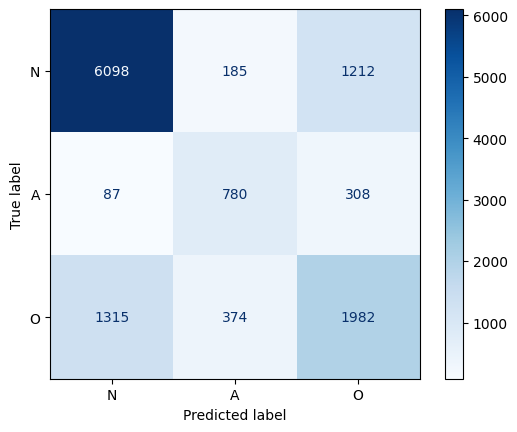

In [8]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.last_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"last_test_loss": test_loss.item()})
    wandb.log({"last_test_auprc": test_auprc.item()})
    wandb.log({"last_test_auroc": test_auroc.item()})
    wandb.log({"last_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"last_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"last_test_cm": test_cm_disp.figure_})

### Best model

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 25/25 [00:02<00:00, 12.38it/s]
test_loss: 0.7805128693580627
test_auprc: 0.7143346667289734
test_auroc: 0.8356711268424988
              precision    recall  f1-score   support

           N       0.80      0.88      0.84      7495
           A       0.60      0.72      0.65      1175
           O       0.65      0.48      0.55      3671

    accuracy                           0.75     12341
   macro avg       0.68      0.69      0.68     12341
weighted avg       0.74      0.75      0.74     12341



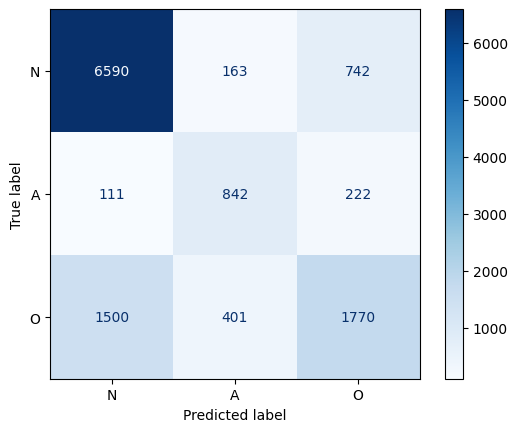

In [9]:
model = DenseNetGruEcgModule.load_from_checkpoint(checkpoint_callback.best_model_path)
results = trainer.predict(model, dataloaders=dm)
test_loss, test_y_pred, test_y, test_y_hat = aggregate_metrics(results)

# loss
print(f"test_loss: {test_loss}")

# auprc
test_auprc = multiclass_average_precision(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auprc: {test_auprc}")

# auroc
test_auroc = multiclass_auroc(test_y_pred, test_y, num_classes=dm.num_classes)
print(f"test_auroc: {test_auroc}")

# classification report
print(classification_report(test_y, test_y_hat, target_names=dm.test_set.classes))

# confusion matrix
test_cm = confusion_matrix(test_y, test_y_hat)
test_cm_disp = ConfusionMatrixDisplay(
    confusion_matrix=test_cm, display_labels=dm.test_set.classes
)
test_cm_disp.plot(cmap="Blues")
plt.show()

# logger
if wandb_mode != "disabled":
    wandb.log({"best_test_loss": test_loss.item()})
    wandb.log({"best_test_auprc": test_auprc.item()})
    wandb.log({"best_test_auroc": test_auroc.item()})
    wandb.log({"best_test_f1": f1_score(test_y, test_y_hat, average="macro")})
    wandb.log({"best_test_accuracy": accuracy_score(test_y, test_y_hat)})
    wandb.log({"best_test_cm": test_cm_disp.figure_})

In [10]:
wandb.finish()